# Workshop 9 - Recommender Systems

## Emilio and Saffian

# Imports

In [2]:
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
import csv
warnings.filterwarnings('ignore')

# Data

In [3]:
df = pd.read_csv('movies_metadata.csv')
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [7]:
credits = pd.read_csv('credits.csv')
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [8]:
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [9]:
keywords = pd.read_csv('keywords.csv')
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


# EDA

In [10]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [12]:
df.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [13]:
df[df['original_title'] != df['title']][['title','original_title']]

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal
...,...,...
45453,Mom,Maa
45455,St. Michael Had a Rooster,San Michele aveva un gallo
45461,Subdue,رگ خواب
45462,Century of Birthing,Siglo ng Pagluluwal


In [14]:
# Drop original title
df = df.drop('original_title', axis=1)

array([[<AxesSubplot: title={'center': 'revenue'}>,
        <AxesSubplot: title={'center': 'runtime'}>],
       [<AxesSubplot: title={'center': 'vote_average'}>,
        <AxesSubplot: title={'center': 'vote_count'}>]], dtype=object)

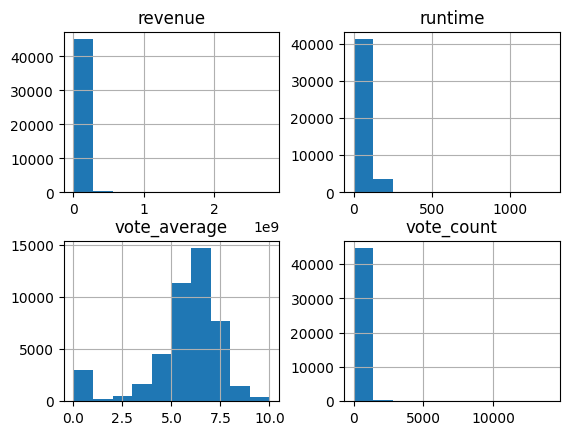

In [15]:
df.hist()

In [16]:
df['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [17]:
#Not significant
df = df.drop('adult', axis=1)
df = df.drop('poster_path', axis=1)

In [18]:
df.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count'],
      dtype='object')

In [19]:
df['revenue'] = df['revenue'].replace(0,np.nan)

In [20]:
df['budget'] = df['budget'].replace(0,np.nan)

In [21]:
df['release_date'].value_counts()

2008-01-01    136
2009-01-01    121
2007-01-01    118
2005-01-01    111
2006-01-01    101
             ... 
1957-09-26      1
1938-11-21      1
1936-08-19      1
2010-01-27      1
1917-10-21      1
Name: release_date, Length: 17336, dtype: int64

In [22]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: x.year if x != np.nan else np.nan)
df['month'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: x.month if x != np.nan else np.nan)
df['weekday'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: x.weekday() if x != np.nan else np.nan)

In [23]:
df['production_countries']

0        [{'iso_3166_1': 'US', 'name': 'United States o...
1        [{'iso_3166_1': 'US', 'name': 'United States o...
2        [{'iso_3166_1': 'US', 'name': 'United States o...
3        [{'iso_3166_1': 'US', 'name': 'United States o...
4        [{'iso_3166_1': 'US', 'name': 'United States o...
                               ...                        
45461               [{'iso_3166_1': 'IR', 'name': 'Iran'}]
45462        [{'iso_3166_1': 'PH', 'name': 'Philippines'}]
45463    [{'iso_3166_1': 'US', 'name': 'United States o...
45464             [{'iso_3166_1': 'RU', 'name': 'Russia'}]
45465     [{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]
Name: production_countries, Length: 45466, dtype: object

In [24]:
# Top ten production countries
df['production_countries'] = df['production_countries'].fillna('[]').apply(ast.literal_eval)
df['production_countries'] = df['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

s = df.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

con_df = df.drop('production_countries', axis=1).join(s)
con_df = pd.DataFrame(con_df['countries'].value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies', 'country']
con_df = con_df.reset_index().drop('index', axis=1)
con_df.head(10)

,num_movies,country
0,21153,United States of America
1,4094,United Kingdom
2,3940,France
3,2254,Germany
4,2169,Italy
5,1765,Canada
6,1648,Japan
7,964,Spain
8,912,Russia
9,828,India


In [25]:
# Production companies
df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)
df['production_companies'] = df['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

com_df = df.drop('production_companies', axis=1).join(s)

com_sum = pd.DataFrame(com_df.groupby('companies')['revenue'].sum().sort_values(ascending=False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['revenue'].mean().sort_values(ascending=False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['revenue'].count().sort_values(ascending=False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

com_pivot.sort_values('Total', ascending=False).head(10)

,Total,Average,Number
companies,,,
Warner Bros.,6.352519e+10,1.293792e+08,491
Universal Pictures,5.525919e+10,1.193503e+08,463
Paramount Pictures,4.880819e+10,1.235650e+08,395
Twentieth Century Fox Film Corporation,4.768775e+10,1.398468e+08,341
Walt Disney Pictures,4.083727e+10,2.778046e+08,147
Columbia Pictures,3.227974e+10,1.367785e+08,236
New Line Cinema,2.217339e+10,1.119868e+08,198
Amblin Entertainment,1.734372e+10,2.550547e+08,68
DreamWorks SKG,1.547575e+10,1.984071e+08,78


In [26]:
com_pivot[com_pivot['Number'] >= 15].sort_values('Average', ascending=False).head(10)

,Total,Average,Number
companies,,,
Pixar Animation Studios,1.118853e+10,6.215852e+08,18
Marvel Studios,1.169964e+10,6.157703e+08,19
Revolution Sun Studios,8.120339e+09,5.413559e+08,15
Lucasfilm,9.898421e+09,4.499282e+08,22
DreamWorks Animation,1.370752e+10,4.031622e+08,34
DC Entertainment,6.212609e+09,3.882880e+08,16
Dentsu,6.853205e+09,3.807336e+08,18
Jerry Bruckheimer Films,8.957441e+09,3.732267e+08,24
Marvel Enterprises,6.538067e+09,3.441088e+08,19


In [27]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

In [28]:
# Most voted
df[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10)

,title,vote_count,year
15480,Inception,14075.0,2010.0
12481,The Dark Knight,12269.0,2008.0
14551,Avatar,12114.0,2009.0
17818,The Avengers,12000.0,2012.0
26564,Deadpool,11444.0,2016.0
22879,Interstellar,11187.0,2014.0
20051,Django Unchained,10297.0,2012.0
23753,Guardians of the Galaxy,10014.0,2014.0
2843,Fight Club,9678.0,1999.0
18244,The Hunger Games,9634.0,2012.0


In [29]:
# Most critically acclaimed
df[df['vote_count'] > 2000][['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head(10)

,title,vote_average,vote_count,year
314,The Shawshank Redemption,8.5,8358.0,1994.0
834,The Godfather,8.5,6024.0,1972.0
2211,Life Is Beautiful,8.3,3643.0,1997.0
5481,Spirited Away,8.3,3968.0,2001.0
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0,1975.0
1176,Psycho,8.3,2405.0,1960.0
2843,Fight Club,8.3,9678.0,1999.0
1178,The Godfather: Part II,8.3,3418.0,1974.0
12481,The Dark Knight,8.3,12269.0,2008.0
292,Pulp Fiction,8.3,8670.0,1994.0


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134]),
 [Text(0, 0, '1874.0'),
  Text(1, 0, '1878.0'),
  Text(2, 0, '1883.0'),
  Text(3, 0, '1887.0'),
  Text(4, 0, '1888.0'),
  Text(5, 0, '1890.0'),
  Text(6, 0, '1891.0'),
  Text(7, 0, '1892.0'),
  Text(8, 0, '1893.0'),
  Text(9, 0, '1894.

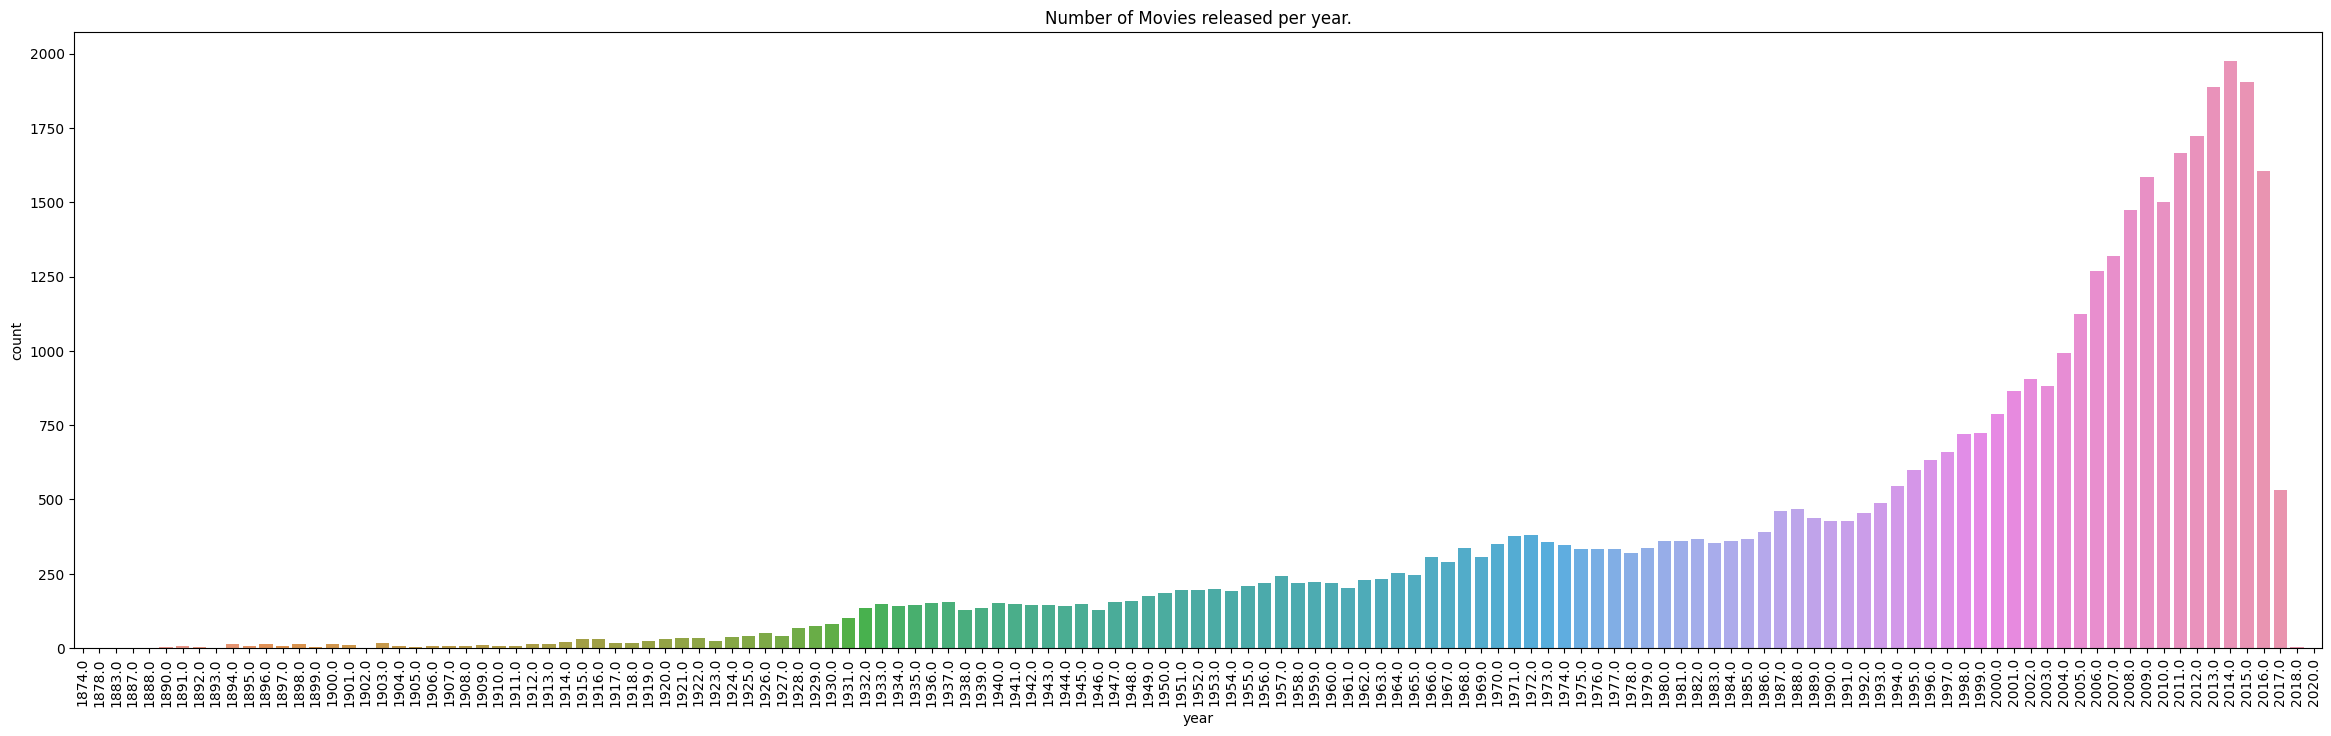

In [30]:
#df['year'] = df['year'].astype('int')
plt.figure(figsize=(29,8))
plt.title("Number of Movies released per year.")
sns.countplot(x='year', data=df)
plt.xticks(rotation=90)

<AxesSubplot: title={'center': 'Number of Movies released per month.'}, xlabel='month', ylabel='count'>

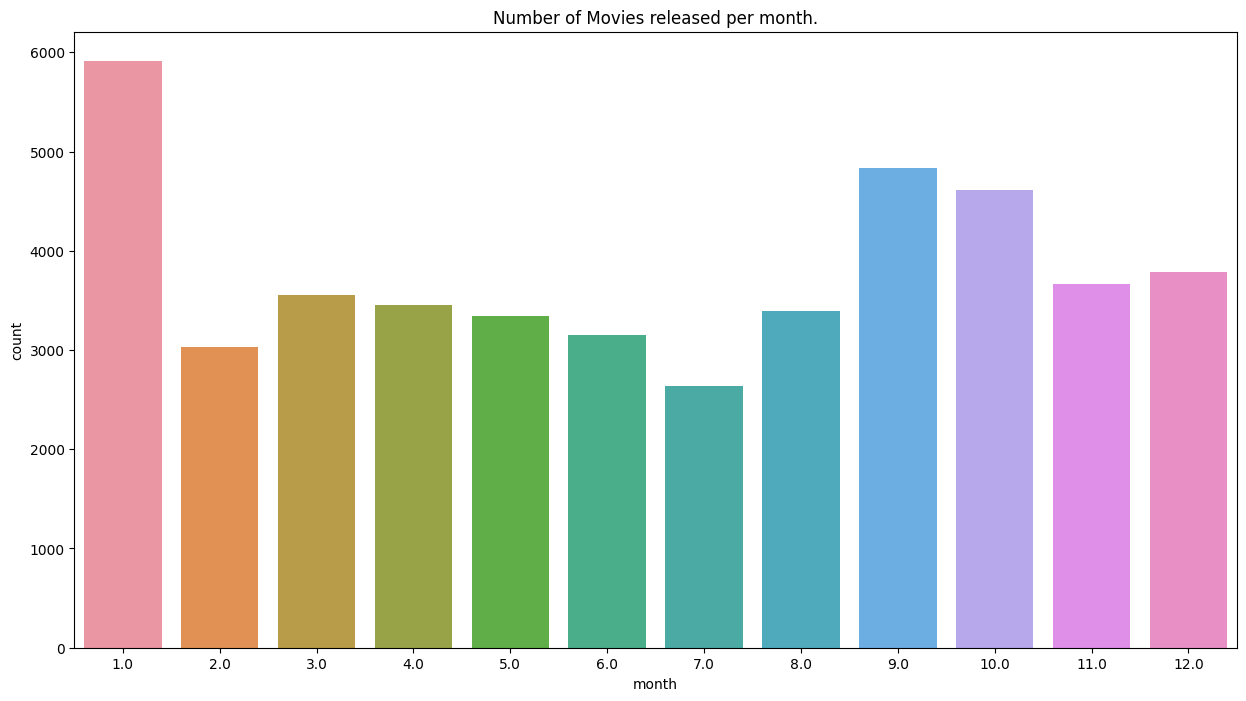

In [31]:
#df['year'] = df['year'].astype('int')
plt.figure(figsize=(15,8))
plt.title("Number of Movies released per month.")
sns.countplot(x='month', data=df)

<AxesSubplot: title={'center': 'Average Gross by the Month for Blockbuster Movies'}, xlabel='mon', ylabel='revenue'>

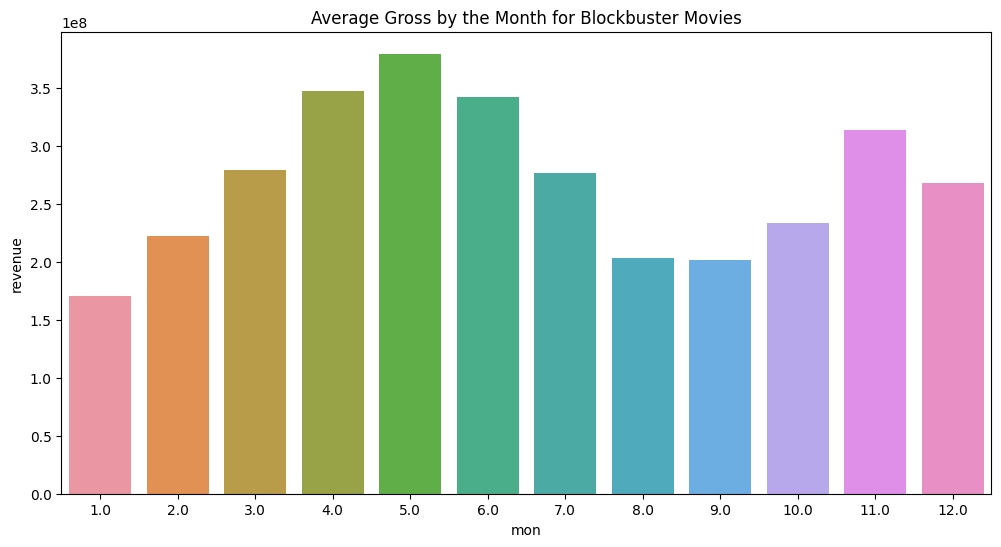

In [32]:
month_mean = pd.DataFrame(df[df['revenue'] > 1e8].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Average Gross by the Month for Blockbuster Movies")
sns.barplot(x='mon', y='revenue', data=month_mean)

<AxesSubplot: title={'center': 'Number of Movies released per weekday.'}, xlabel='weekday', ylabel='count'>

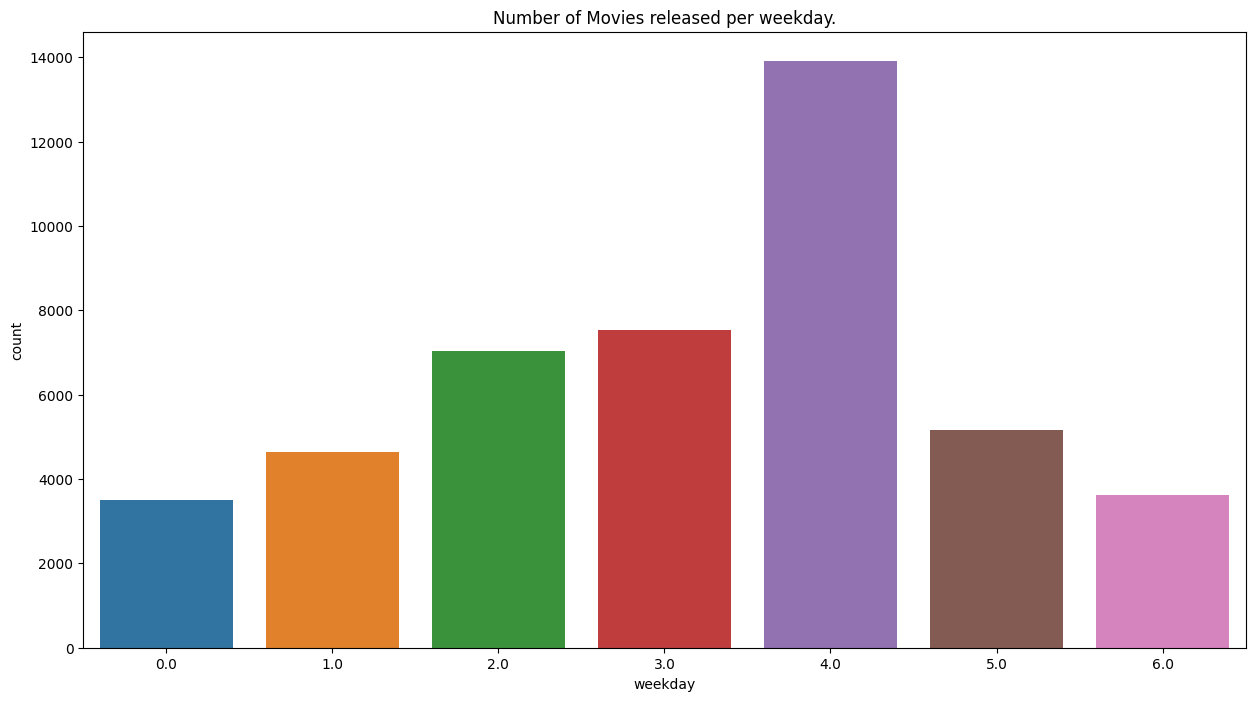

In [33]:
plt.figure(figsize=(15,8))
plt.title("Number of Movies released per weekday.")
sns.countplot(x='weekday', data=df)

<AxesSubplot: xlabel='runtime', ylabel='Density'>

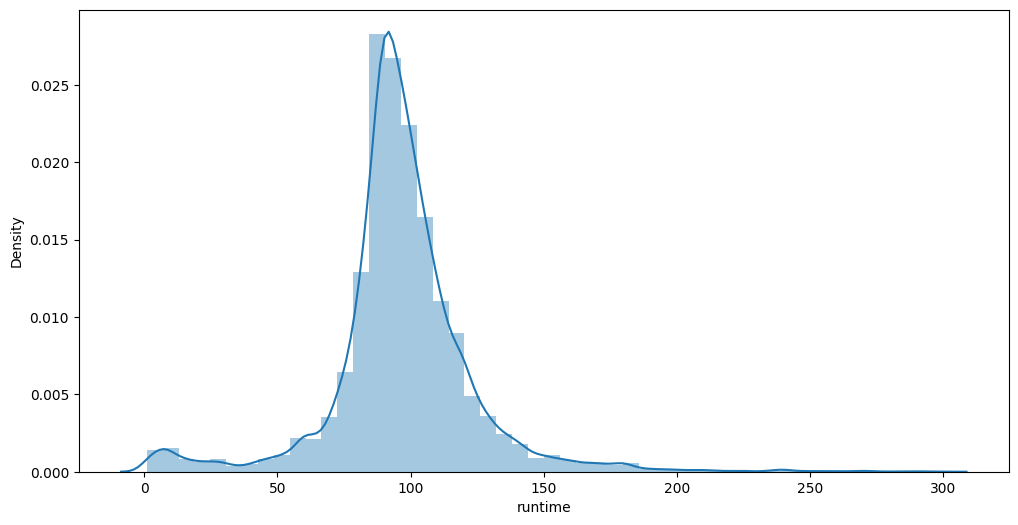

In [34]:
plt.figure(figsize=(12,6))
sns.distplot(df[(df['runtime'] < 300) & (df['runtime'] > 0)]['runtime'])

In [35]:
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df[df['budget'].notnull()][['title', 'budget', 'year']].sort_values('budget', ascending=False).head(10)

,title,budget,year
17124,Pirates of the Caribbean: On Stranger Tides,380000000.0,2011.0
11827,Pirates of the Caribbean: At World's End,300000000.0,2007.0
26558,Avengers: Age of Ultron,280000000.0,2015.0
11067,Superman Returns,270000000.0,2006.0
16130,Tangled,260000000.0,2010.0
18685,John Carter,260000000.0,2012.0
44842,Transformers: The Last Knight,260000000.0,2017.0
11780,Spider-Man 3,258000000.0,2007.0
21175,The Lone Ranger,255000000.0,2013.0
19971,The Hobbit: An Unexpected Journey,250000000.0,2012.0


In [36]:

df[df['budget'].notnull()][['title',  'revenue', 'year']].sort_values('revenue', ascending=False).head(10)

,title,revenue,year
14551,Avatar,2.787965e+09,2009.0
26555,Star Wars: The Force Awakens,2.068224e+09,2015.0
1639,Titanic,1.845034e+09,1997.0
17818,The Avengers,1.519558e+09,2012.0
25084,Jurassic World,1.513529e+09,2015.0
28830,Furious 7,1.506249e+09,2015.0
26558,Avengers: Age of Ultron,1.405404e+09,2015.0
17437,Harry Potter and the Deathly Hallows: Part 2,1.342000e+09,2011.0
22110,Frozen,1.274219e+09,2013.0
42222,Beauty and the Beast,1.262886e+09,2017.0


In [37]:
# by genre
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

gen_df = df.drop('genres', axis=1).join(s)

pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(10)

,genre,movies
0,Drama,20265
1,Comedy,13182
2,Thriller,7624
3,Romance,6735
4,Action,6596
5,Horror,4673
6,Crime,4307
7,Documentary,3932
8,Adventure,3496
9,Science Fiction,3049


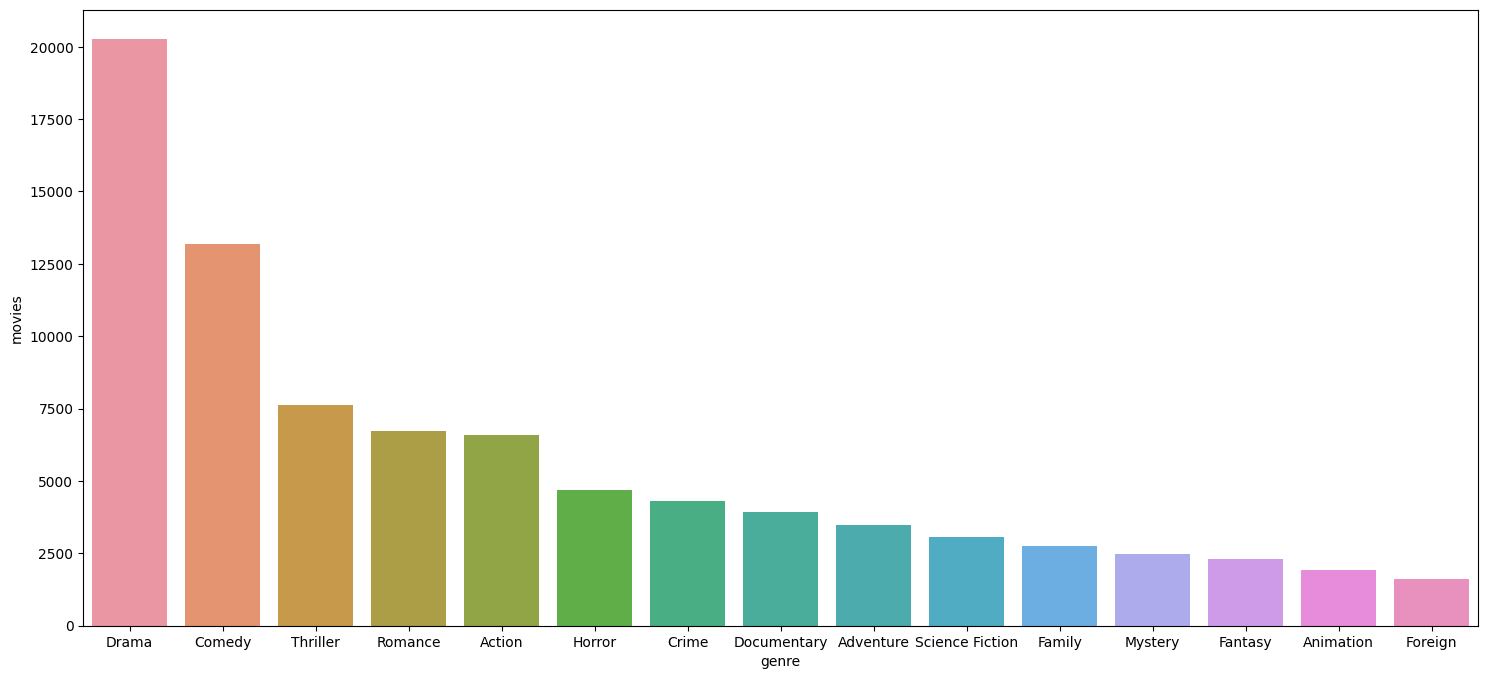

In [38]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.show()

# Simple Recommender

In [39]:
from ast import literal_eval

In [44]:
df = pd. read_csv('movies_metadata.csv')
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [45]:
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [46]:
vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [47]:
m = vote_counts.quantile(0.95)
m

434.0

In [48]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [49]:
qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [50]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [51]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False).head(250)
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


In [52]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = df.drop('genres', axis=1).join(s)

In [53]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [54]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


# Content Based Recommender

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer

In [56]:
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
md = df.drop([19730, 29503, 35587])
md['id'] = md['id'].astype('int')
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

In [57]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [58]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [59]:
tfidf_matrix.shape

(9099, 268124)

In [60]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [61]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [62]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [63]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [64]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [65]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

# Metadata Based Recommender

In [66]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [67]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [68]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [69]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

In [70]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [71]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [72]:
smd['director'] = smd['crew'].apply(get_director)

In [73]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [74]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [75]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [93]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])

In [94]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [95]:
s = s.value_counts()
s[5:]

music           302
violenc         264
love            222
sex             219
suspens         214
               ... 
mambo             2
allmalecast       2
keithmallori      2
partisan          2
deadendjob        2
Name: keyword, Length: 6461, dtype: int64

In [96]:
s = s[s > 1]

In [97]:
stemmer = SnowballStemmer('english')
stemmer.stem('rises')

'rise'

In [98]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [99]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [100]:
smd['all'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['all'] = smd['all'].apply(lambda x: ' '.join(x))

In [101]:
smd['all'].head()

0    jealousi toy boy friendship friend rivalri boy...
1    boardgam disappear basedonchildren'sbook newho...
2    fish bestfriend duringcreditsst waltermatthau ...
3    basedonnovel interracialrelationship singlemot...
4    babi midlifecrisi confid age daughter motherda...
Name: all, dtype: object

In [102]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['all'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [103]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

In [104]:
get_recommendations('Don Jon').head(10)

843     Angels in the Outfield
4632                     Manic
7904              Elektra Luxx
7340      (500) Days of Summer
7977                     50/50
6468                     Brick
7947                    Hesher
9088          The Night Before
73                   The Juror
6193           Mysterious Skin
Name: title, dtype: object